First we write some starter code to generate data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
font = {'size': 18}
matplotlib.rc('font', **font)

%matplotlib inline

In [3]:
# Define the true function f
def f(x):
    return 100 * (x - 0.5) ** 3 - 10 * x + 2 * x + 2 * 6.25

In [4]:
# Generate a list of x's so we can properly draw the model
xs = np.linspace(0, 1, 1000).reshape((1000, 1))

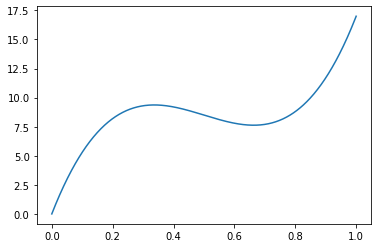

In [5]:
plt.plot(xs, f(xs))

In [6]:
# Generate 20 random data points
X = np.random.uniform(0 , 1, 20).reshape((20, 1))
X

array([[0.96743095],
       [0.47912847],
       [0.02379608],
       [0.42769148],
       [0.91669042],
       [0.40320116],
       [0.1270046 ],
       [0.82180328],
       [0.51829916],
       [0.46049639],
       [0.10105563],
       [0.02822755],
       [0.56449953],
       [0.91477021],
       [0.29159442],
       [0.71900778],
       [0.28545475],
       [0.90117543],
       [0.60099308],
       [0.27489496]])

In [7]:
# Generate 20 noisy targets for training data
y = f(X) + np.random.normal(0, 1, (20, 1))

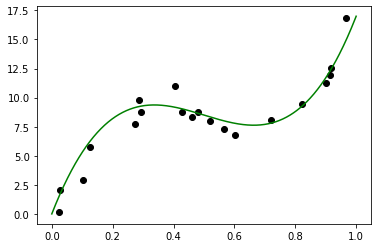

In [8]:
# Plot them together
plt.plot(xs, f(xs), color='green')
plt.scatter(X, y, color='black')

# Demo 1: Overfitting
This demo shows how the degree polynomial fit can cause overfitting for a fixed sized dataset

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def poly_model(degree, X, y, xs):
    # Generate polynomial features of degree p
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    xs_poly = poly.transform(xs)

    # Train the model and make predictions along all xs
    model = LinearRegression()
    model.fit(X_poly, y)
    predictions = model.predict(xs_poly)

    # Plot the prediction results
    plt.scatter(X, y, label='Data', c='black')
    plt.plot(xs, predictions, label='Predicted f')

    # Customize plot for readability
    plt.title(f'Degree {degree}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")  # Legend outside plot
    plt.xlim(0, 1)
    plt.ylim(0, y.max() + 1)

    plt.show()

In [10]:
# Code to create the interactive widget
from ipywidgets import fixed, interactive, IntSlider, widget, widgets

interactive_plot = interactive(poly_model, 
                               degree=IntSlider(min=0, max=30),
                               X=fixed(X),
                               y=fixed(y),
                               xs=fixed(xs))

output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=0, description='degree', max=30), Output(layout=Layout(height='350px')))…

# Demo 2: Overfitting Coefficients
This demo shows how the magnitude of the coefficients changes as we increase the degree of the polynomial. 
Notice that the y-scale is long so the biggest values are on the order of $10^{14}$!

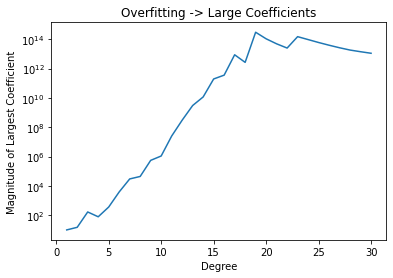

In [11]:
degrees = list(range(1, 31))
largest_coeffs = []

for p in degrees:  
    # Generate data with polynomial features of degree p
    poly = PolynomialFeatures(p)
    X_poly = poly.fit_transform(X)
    xs_poly = poly.transform(xs)

    # Train the model 
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Find largest coefficient
    coeff = np.abs(model.coef_).max()
    largest_coeffs.append(coeff)
    
# Plot the coefficients
plt.plot(degrees, largest_coeffs)
plt.title('Overfitting -> Large Coefficients')
plt.xlabel('Degree')
plt.ylabel('Magnitude of Largest Coefficient')
plt.yscale('log')

# Demo 3: Size of Dataset
This demo shows hwo the number of datapoints matter for overfitting. If we use a high degree polynomial and a small dataset, its more likely to overfit. If we use the same degree polynomial but on a larger dataset, it is harder to overfit

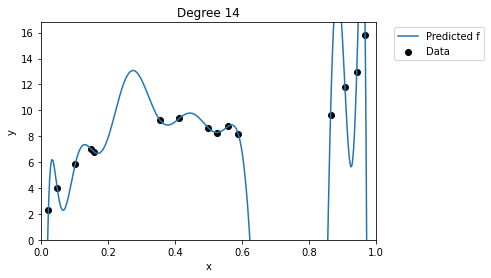

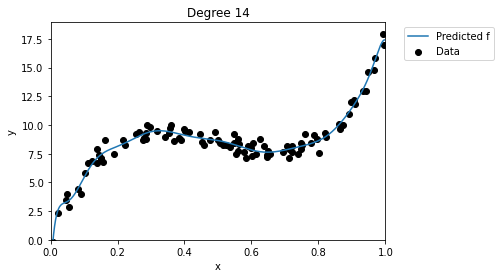

In [12]:
# Generate 100 random data points
X_100 = np.random.uniform(0 , 1, 100).reshape((100, 1))
y_100 = f(X_100) + np.random.normal(0, 0.5, (100, 1))

# Train a 14 degree polynomial on 15 points
poly_model(14, X_100[:15], y_100[:15], xs)
# Train a 14 degree polynomial on 100 points
poly_model(14, X_100, y_100, xs)

# Demo 5: Ridge Regression
This demo shows how the penalty for $\lambda$ affects the resulting function

In [13]:
# Simple code to train a Ridge model
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.5)

In [14]:
# Define the function for plotting
def poly_model_ridge(lam, degree, X, y, xs, ):
    # Generate polynomial features of degree p
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    xs_poly = poly.transform(xs)

    # Train the model and make predictions along all xs
    model = Ridge(alpha=lam)
    model.fit(X_poly, y)
    predictions = model.predict(xs_poly)

    # Plot the prediction results
    plt.scatter(X, y, label='Data', c='black')
    plt.plot(xs, predictions, label='Predicted f')

    # Customize plot for readability
    plt.title(f'Lambda {lam:0.2e}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")  # Legend outside plot
    plt.xlim(0, 1)
    plt.ylim(0, y.max() + 1)

    plt.show()

In [15]:
# Define interaction code
from ipywidgets import fixed, interactive, FloatLogSlider, widget, widgets

interactive_plot = interactive(poly_model_ridge, 
                               lam=FloatLogSlider(min=-3, max=3, value=-3),
                               degree=fixed(14),
                               X=fixed(X),
                               y=fixed(y),
                               xs=fixed(xs))

output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatLogSlider(value=0.001, description='lam', max=3.0, min=-3.0), Output(layout=Layout(…

# Demo 6: Visualizing Ridge Regression
First, some set up work to setup the initial state to make computations faster

In [16]:
import math

from ipywidgets import interactive, FloatLogSlider, FloatSlider, widget, widgets
from IPython.display import display

from matplotlib import ticker

# Make a datset that has features of all 1s for the intercept
X_mod = np.ones((X.shape[0], 2))
X_mod[:, 1] = X[:, 0]


def compute_ridge_path(X, y, lambdas):
    """
    Computes the Ridge Regression coefficient path for the given list of lambdas
    
    Trains a Ridge model for each value of lambda and returns the coefficients
    as a (2, len(lambdas)) array storing the coefficients as columns.
    """
    coefs = np.zeros((2, len(lambdas)))
    for i, lam in enumerate(lambdas):
        model = Ridge(alpha=lam, fit_intercept=False)
        model.fit(X, y)
        coefs[:, i] = model.coef_[0, :].T
    return coefs
    
    
def rss(X, y, w0s, w1s):
    """
    Compute the value of the RSS metric for each combo of w0 and w1
    
    Returns a numpy array of RSS values of size ((w0s.size, w1s.size))
    """
    rss_values = np.zeros(shape=(w0s.size, w1s.size))

    # For every setting of w0 and w1
    for i, w0 in enumerate(w0s):
        for j, w1 in enumerate(w1s):
            w = np.array([w0, w1]).reshape((2,1))
            # This computes RSS(w)
            rss_values[j, i] = np.sum((y - X @ w) ** 2) 
    return rss_values

# Set up common state
lambda_params = (-5, 3)
lambdas = np.logspace(lambda_params[0], lambda_params[1], 50)
coefs = compute_ridge_path(X_mod, y, lambdas)
w0s = np.linspace(-15, 15, 200)
w1s = np.linspace(-15, 15, 200)
# Clever: We only have to compute RSS once since it only dpeends on data and possible w0s and w1s
rss_values = rss(X_mod, y, w0s=w0s, w1s=w1s)

In [17]:
def plot_contour(axis, w0s, w1s, values):
    """
    Plots a contour plot on the given axis using w0s as the x-axis,
    w1s as the y-axis, and values as the z-axis.
    """
    # First, plot the color gradient
    axis.contourf(w0s, w1s, values, levels=100, alpha=.5)
    
    # Then plot the labelled contours
    cs = axis.contour(w0s, w1s, values, levels=10, colors='black')
    axis.clabel(cs, inline=1, fontsize=8)
    
    # Then draw the x and y axes
    axis.axhline(0, color='black', alpha=.5, dashes=[2, 4], linewidth=1)
    axis.axvline(0, color='black', alpha=0.5, dashes=[2, 4], linewidth=1)
    axis.set_xlim(w0s.min(), w0s.max())
    axis.set_ylim(w1s.min(), w1s.max())

    
# Setup the objects that hold widget state
w0_widget  = FloatSlider(min=math.floor(w0s.min()), max=math.ceil(w0s.max()), continuous_update=False)
w1_widget  = FloatSlider(min=math.floor(w1s.min()), max=math.ceil(w1s.max()), continuous_update=False)
lam_widget = FloatLogSlider(min=lambda_params[0], max=lambda_params[1], value=lambda_params[0], continuous_update=False)

def do_ols(event):
    """
    When clicked, will fit a LinearRegression model to the data and change the values for the widgets
    """
    model = LinearRegression(fit_intercept=False)
    model.fit(X_mod, y)
    w0_widget.value = model.coef_[0, 0]
    w1_widget.value = model.coef_[0, 1]
    


def do_ridge(event):
    """
    When clicked, will fit a Ridge model to the data and change the values for the widgets
    """
    model = Ridge(alpha=lam_widget.value, fit_intercept=False)
    model.fit(X_mod, y)
    w0_widget.value = model.coef_[0, 0]
    w1_widget.value = model.coef_[0, 1]
    
# Create the buttons
button_ols = widgets.Button(
    description='Find Ordinary Least Squares Solution',
    layout={'width': '300px'}
)
button_ols.on_click(do_ols) 
button_ridge = widgets.Button(
    description='Find Ridge Regression Solution',
    layout={'width': '300px'}
)
button_ridge.on_click(do_ridge)


def plot(w0, w1, lam, show_path):
    """
    Plots the graph showing the quality metric at the different w0 and w1 pairs using lambda strength
    lam for Ridge regression. If show_path is True, shows coefficient paths.
    """
    if show_path:
        fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(ncols=3, nrows=2, figsize=(30, 15))
        ax4.axis('off')
        ax6.axis('off')
    else:
        fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(30, 7))
        

    xs = np.linspace(0, 1, 100)
    
    # Plot the data on ax1
    ax1.scatter(X, y, c='black', label='Data')
    ax1.plot(xs, w0 + w1 * xs, label=f'y = {w0:.2f} + {w1:.2f}x')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(-0.05, y.max() + 1)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Data + Prediction')
    ax1.legend()
    
    # Plot 2 shows RSS alone
    plot_contour(ax2, w0s, w1s, rss_values)
    if show_path:
        ax2.plot(coefs[0, :], coefs[1, :], c='w')
    ax2.scatter(np.array([w0]), np.array([w1]), edgecolor='black', facecolor='white', s=100)
    ax2.set_title('Ordinary Least Squares QM')
    ax2.set_xlabel('w0')
    ax2.set_ylabel('w1')
    
    # Plot 3 shows RSS + L2 Norm
    ridge_penalties = w0s.reshape((w1s.shape[0], 1)) ** 2 + w0s ** 2
    plot_contour(ax3, w0s, w1s, rss_values + lam * ridge_penalties)
    if show_path:
        ax3.plot(coefs[0, :], coefs[1, :], c='w')
    ax3.scatter(np.array([w0]), np.array([w1]), edgecolor='black', facecolor='white', s=100)
    ax3.set_xlabel('w0')
    ax3.set_ylabel('w1')
    ax3.set_title(f'Ridge Regression QM: Lambda={lam:.2e}')

    
    # Show the standard coefficient path chart
    if show_path:
        ax5.plot(lambdas, coefs[0, :], label='w0')
        ax5.plot(lambdas, coefs[1, :], label='w1')
        
        ax5.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        ax5.set_xscale('log')
        ax5.set_xlabel('lambda')
        ax5.set_ylabel('magnitude')
        ax5.set_title('Coefficient Path')
        
    plt.show()

interactive_plot = interactive(plot, w0=w0_widget, w1=w1_widget, lam=lam_widget, show_path=False)
output = interactive_plot.children[-1]
output.layout.height = '800px'

Ordinary Least Squares
$$\hat{w}_{LS} = \min_w RSS(w)$$

Ridge Regression

$$\hat{w}_{ridge} = \min_w RSS(w) + \lambda ||w||_2^2$$



---

*Note:* In general we want to avoid penalizing the intercept coefficient. We'll discuss this more later, but just note that this demo does a slightly "wrong" thing here by penalizing the intercept. We do this to keep the demo as simple as possible. You can see the very last section of this notebook has the "correct" behavior that does not penalize the intercept.



In [18]:
display(widgets.HBox([button_ols, button_ridge]))
interactive_plot

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='w0', max=15.0, min=-15.0), …

# Demo 6b: Visualizing Ridge Regression - Don't Penalize Intercept
Here is the exact repeat of all the code from before, but that doesn't penalize $w_0$

In [19]:
import math

from ipywidgets import interactive, FloatLogSlider, FloatSlider, widget, widgets
from IPython.display import display

from matplotlib import ticker

def compute_ridge_path2(X, y, lambdas):
    coefs = np.zeros((2, len(lambdas)))
    for i, lam in enumerate(lambdas):
        model = Ridge(alpha=lam, fit_intercept=True)
        model.fit(X, y)
        coefs[0, i] = model.intercept_
        coefs[1, i] = model.coef_[0, 0]
    return coefs

    
def rss2(X, y, w0s, w1s):
    rss_values = np.zeros(shape=(w0s.size, w1s.size))

    # For every setting of w0 and w1
    for i, w0 in enumerate(w0s):
        for j, w1 in enumerate(w1s):
            # This computes RSS(w)
            rss_values[j, i] = np.sum((y - (w0 + X * w1)) ** 2) 
    return rss_values

lambda_params2 = (-5, 3)
lambdas2 = np.logspace(lambda_params2[0], lambda_params2[1], 50)
coefs2 = compute_ridge_path2(X, y, lambdas2)
w0s2 = np.linspace(-15, 15, 200)
w1s2 = np.linspace(-15, 15, 200)
rss_values2 = rss2(X, y, w0s=w0s2, w1s=w1s2)
coefs2

array([[3.43023209, 3.43024453, 3.43026265, 3.43028903, 3.43032746,
        3.43038343, 3.43046493, 3.43058363, 3.43075647, 3.43100818,
        3.4313747 , 3.43190839, 3.43268541, 3.43381659, 3.43546304,
        3.43785886, 3.44134382, 3.44641024, 3.45376993, 3.46444855,
        3.47991682, 3.5022686 , 3.53445393, 3.58056552, 3.64615322,
        3.73849019, 3.86662418, 4.04091881, 4.27167505, 4.56647911,
        4.92641156, 5.34230634, 5.7933479 , 6.25009087, 6.68159579,
        7.06333801, 7.38192009, 7.6351004 , 7.82859681, 7.97210954,
        8.07619975, 8.15048009, 8.20287527, 8.23953109, 8.26502854,
        8.28269347, 8.29489801, 8.30331385, 8.30910946, 8.313097  ],
       [9.95526302, 9.9552377 , 9.95520082, 9.95514712, 9.95506891,
        9.95495501, 9.95478913, 9.95454758, 9.9541958 , 9.95368354,
        9.95293761, 9.95185147, 9.9502701 , 9.94796797, 9.94461717,
        9.93974127, 9.93264882, 9.92233781, 9.90735963, 9.88562688,
        9.85414642, 9.80865686, 9.74315441, 9.6

In [21]:
def plot_contour(axis, w0s, w1s, values):
    # First, plot the color gradient
    axis.contourf(w0s, w1s, values, levels=100, alpha=.5)
    
    # Then plot the labelled contours
    cs = axis.contour(w0s, w1s, values, levels=10, colors='black')
    axis.clabel(cs, inline=1, fontsize=8)
    
    # Then draw the x and y axes
    axis.axhline(0, color='black', alpha=.5, dashes=[2, 4], linewidth=1)
    axis.axvline(0, color='black', alpha=0.5, dashes=[2, 4], linewidth=1)
    axis.set_xlim(w0s.min(), w0s.max())
    axis.set_ylim(w1s.min(), w1s.max())

    
# Setup the objects that hold widget state
w0_widget2  = FloatSlider(min=math.floor(w0s2.min()), max=math.ceil(w0s2.max()), continuous_update=False)
w1_widget2  = FloatSlider(min=math.floor(w1s2.min()), max=math.ceil(w1s2.max()), continuous_update=False)
lam_widget2 = FloatLogSlider(min=lambda_params2[0], max=lambda_params2[1], value=lambda_params2[0], continuous_update=False)


# Define the buttons that will find the OLS or ridge solutions
def do_ols2(event):
    model = LinearRegression()
    model.fit(X, y)
    w0_widget2.value = model.intercept_
    w1_widget2.value = model.coef_[0, 0]
    
    
def do_ridge2(event):
    model = Ridge(alpha=lam_widget2.value)
    model.fit(X, y)
    w0_widget2.value = model.intercept_
    w1_widget2.value = model.coef_[0, 0]
    
# Creat the buttons 
button_ols2 = widgets.Button(
    description='Find Ordinary Least Squares Solution',
    layout={'width': '300px'}
)
button_ols2.on_click(do_ols2)   
button_ridge2 = widgets.Button(
    description='Find Ridge Regression Solution',
    layout={'width': '300px'}
)
button_ridge2.on_click(do_ridge2)


def plot(w0, w1, lam, show_path):
    if show_path:
        fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(ncols=3, nrows=2, figsize=(30, 15))
        ax4.axis('off')
        ax6.axis('off')
    else:
        fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(30, 7))
        

    xs = np.linspace(0, 1, 100)
    
    # Plot the data on ax1
    ax1.scatter(X, y, c='black', label='Data')
    ax1.plot(xs, w0 + w1 * xs, label=f'y = {w0:.2f} + {w1:.2f}x')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(-0.05, y.max() + 1)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Data + Prediction')
    ax1.legend()
    
    # Plot 2 shows RSS alone
    plot_contour(ax2, w0s2, w1s2, rss_values2)
    if show_path:
        ax2.plot(coefs2[0, :], coefs2[1, :], c='w')
    ax2.scatter(np.array([w0]), np.array([w1]), edgecolor='black', facecolor='white', s=100)
    ax2.set_title('Ordinary Least Squares QM')
    ax2.set_xlabel('w0')
    ax2.set_ylabel('w1')
    
    # Plot 3 shows RSS + L2 Norm
    ridge_penalties = w1s2.reshape((w1s2.shape[0], 1)) ** 2 + np.zeros((w1s2.shape[0]))
    plot_contour(ax3, w0s2, w1s2, rss_values2 + lam * ridge_penalties)
    if show_path:
        ax3.plot(coefs2[0, :], coefs2[1, :], c='w')
    ax3.scatter(np.array([w0]), np.array([w1]), edgecolor='black', facecolor='white', s=100)
    ax3.set_xlabel('w0')
    ax3.set_ylabel('w1')
    ax3.set_title(f'Ridge Regression QM: Lambda={lam:.2e}')

    
    # Show the s2tandard coefficient path chart
    if show_path:
        ax5.plot(lambdas, coefs2[0, :], label='w0')
        ax5.plot(lambdas, coefs2[1, :], label='w1')
        
        ax5.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        ax5.set_xscale('log')
        ax5.set_xlabel('lambda')
        ax5.set_ylabel('magnitude')
        ax5.set_title('Coefficient Path')
        
    plt.show()

interactive_plot2 = interactive(plot, w0=w0_widget2, w1=w1_widget2, lam=lam_widget2, show_path=False)
output = interactive_plot2.children[-1]
output.layout.height = '800px'

In [22]:
display(widgets.HBox([button_ols2, button_ridge2]))
interactive_plot2

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='w0', max=15.0, min=-15.0), …